### T cell subset extraction

**Objective**
Isolate T cells from the global PBMC dataset in order to perform a focused, biologically meaningful analysis of T-cell states and their distribution across clinical conditions.

This step reduces cellular heterogeneity and allows clearer interpretation of T-cell–specific activation, differentiation, and compositional changes associated with Influenza infection and pregnancy.

**Input**
- Annotated PBMC AnnData object generated in Notebook 05/06, containing:
       - Cell-type annotations (cell_type).
       - Condition labels (condition).
       - Quality-controlled and normalized expression data.

**Methods**
- Select cells annotated as T cells based on the global PBMC annotation.
- Create a T cell–only AnnData object.
- Recompute normalization and highly variable genes within the T-cell subset to ensure:
      - Appropriate scaling for downstream embedding and clustering.
      - Removal of biases introduced by non–T-cell populations.
- Restrict downstream comparisons to biologically valid groups
(HC, IA, PHC, PI), while excluding pediatric infected samples due to the lack of appropriate controls.

**Output**
- A curated T cell–only AnnData object suitable for downstream analysis, including:
      - reduction and clustering.
      - T-cell subtype annotation.
      - Quantification of T-cell state distributions across conditions.
      - Preparation for deeper subtype-specific analyses (Notebook 08).

**Notes**

- This step focuses on compositional and state-level characterization, not differential expression.
- Subtype annotation is intentionally conservative, based on available marker genes.
- Ambiguous or transitional populations are retained to avoid over-interpretation.

In [2]:
# Load object 

import os
import scanpy as sc

# Confirm current working directory (should be inside 2_analysis/)
print("CWD:", os.getcwd())

# Load the final AnnData object (saved at project-level results/)
adata = sc.read_h5ad("../results/adata_final.h5ad")

# Quick sanity check
adata


CWD: /mnt/c/Users/yasmi/OneDrive/Desktop/Mini-Projets/scRNA_Influenza_Patients/2_analysis


/home/yasmina/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 103202 × 2000
    obs: 'gsm', 'sample_id', 'condition', 'replicate', 'batch', 'leiden', 'cell_type'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# Subset T cells only (based on the global cell_type annotation from NB06)
adata_t = adata[adata.obs["cell_type"] == "T"].copy()

# Sanity checks: how many T cells and how they distribute across conditions
print("T cells:", adata_t.n_obs)
print("\nT cells per condition:")
print(adata_t.obs["condition"].value_counts())

T cells: 9539

T cells per condition:
condition
IC     3495
PHC    2403
HC     1900
PI     1019
IA      722
Name: count, dtype: int64


In [6]:
#Prepare analysis object + normalize + HVG
import scanpy as sc

# Keep a comparisons-only object (adult + pregnancy groups), excluding pediatric infected (IC)
adata_t_cmp = adata_t[adata_t.obs["condition"].isin(["HC", "IA", "PHC", "PI"])].copy()

# Normalize and log-transform (T cells only)
sc.pp.normalize_total(adata_t_cmp, target_sum=1e4)
sc.pp.log1p(adata_t_cmp)

# Highly variable genes (HVG) selection
sc.pp.highly_variable_genes(adata_t_cmp, n_top_genes=2000, flavor="seurat")

# Subset to HVGs for downstream PCA/UMAP/clustering
adata_t_cmp = adata_t_cmp[:, adata_t_cmp.var["highly_variable"]].copy()

# Sanity check
print("T cells (comparisons-only):", adata_t_cmp.n_obs)
print("HVGs:", adata_t_cmp.n_vars)
print("\nConditions kept:")
print(adata_t_cmp.obs["condition"].value_counts())


/home/yasmina/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


T cells (comparisons-only): 6044
HVGs: 1103

Conditions kept:
condition
PHC    2403
HC     1900
PI     1019
IA      722
Name: count, dtype: int64


/home/yasmina/miniconda3/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  return fn(*args_all, **kw)
/home/yasmina/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
# Fix duplicates + avoidin double log
import numpy as np
import scanpy as sc

# Make cell IDs unique to avoid downstream issues
adata_t_cmp.obs_names_make_unique()

# If data is already log-transformed, do NOT apply log1p again.
# We still ensure the object is normalized consistently for T-cell-only analysis.
sc.pp.normalize_total(adata_t_cmp, target_sum=1e4)

# Only log1p if values look unlogged (rule of thumb: max > ~50 suggests raw counts)
x_max = float(np.max(adata_t_cmp.X))
print("Max value in X (after normalize_total):", x_max)

if x_max > 50:
    print("Applying log1p (data looks unlogged).")
    sc.pp.log1p(adata_t_cmp)
else:
    print("Skipping log1p (data already looks log-transformed).")

# Recompute HVGs after normalization (more consistent)
sc.pp.highly_variable_genes(adata_t_cmp, n_top_genes=2000, flavor="seurat")
adata_t_cmp = adata_t_cmp[:, adata_t_cmp.var["highly_variable"]].copy()

print("HVGs:", adata_t_cmp.n_vars)


Max value in X (after normalize_total): 2604.1630859375
Applying log1p (data looks unlogged).
HVGs: 1103


In [8]:
#Create a clean T-cell object for analysis 
import scanpy as sc

# Create a clean copy for downstream steps (PCA/UMAP/Leiden)
adata_t_an = adata_t_cmp.copy()

# Store a safe copy of current X in a layer (so we can always inspect/rollback)
adata_t_an.layers["X_input"] = adata_t_an.X.copy()

# Ensure unique cell IDs
adata_t_an.obs_names_make_unique()

# Standardize: normalize + log1p (we do it once here, on this analysis object)
sc.pp.normalize_total(adata_t_an, target_sum=1e4)
sc.pp.log1p(adata_t_an)

# HVGs (recomputed after normalization/log)
sc.pp.highly_variable_genes(adata_t_an, n_top_genes=2000, flavor="seurat")
adata_t_an = adata_t_an[:, adata_t_an.var["highly_variable"]].copy()

print("T cells (analysis object):", adata_t_an.n_obs)
print("HVGs:", adata_t_an.n_vars)

T cells (analysis object): 6044
HVGs: 1103


In [9]:
# PCA, neighbors, UMAP, Leiden 

import scanpy as sc

# Scale data (recommended before PCA); cap extreme values for stability
sc.pp.scale(adata_t_an, max_value=10)

# PCA
sc.tl.pca(adata_t_an, svd_solver="arpack")

# Build neighborhood graph
sc.pp.neighbors(adata_t_an, n_neighbors=15, n_pcs=30)

# UMAP embedding
sc.tl.umap(adata_t_an)

# Clustering (Leiden)
sc.tl.leiden(adata_t_an, resolution=0.6, key_added="leiden_t")

# Quick summaries
print("Leiden clusters:")
print(adata_t_an.obs["leiden_t"].value_counts().sort_index())

/home/yasmina/miniconda3/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/yasmina/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_47756/531800617.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_t_an, resolution=0.6, key_added="leiden_t")


Leiden clusters:
leiden_t
0     1803
1     1033
2      562
3      447
4      374
5      342
6      302
7      267
8      219
9      175
10     159
11     142
12     110
13     109
Name: count, dtype: int64


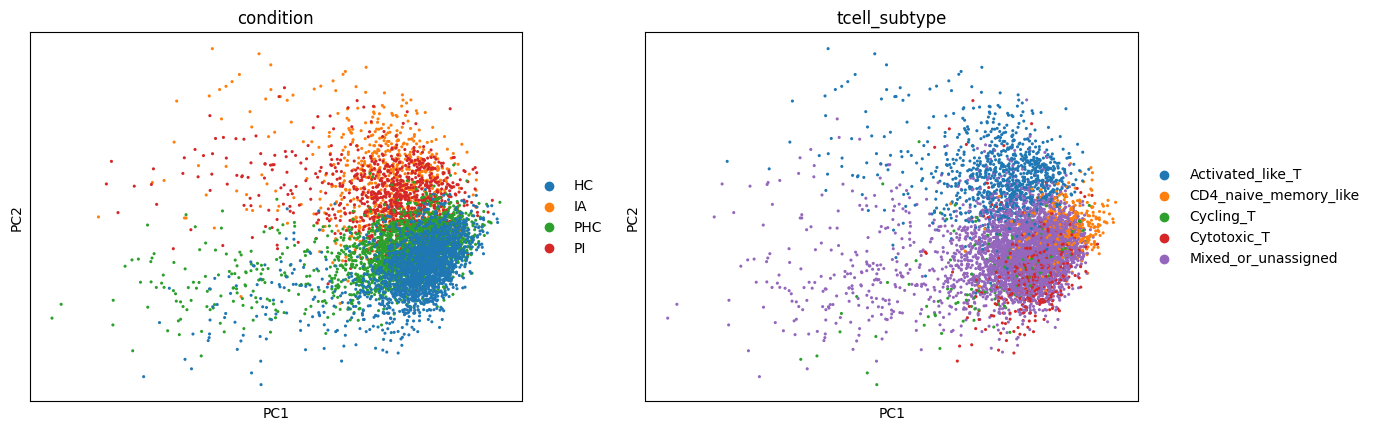

In [29]:
# PCA visualization (T cells)
# PCA visualization for T cells (quality control / global structure)
sc.pl.pca(
    adata_t_an,
    color=["condition", "tcell_subtype"],
    ncols=2,
    show=True
)

Has X_umap: True


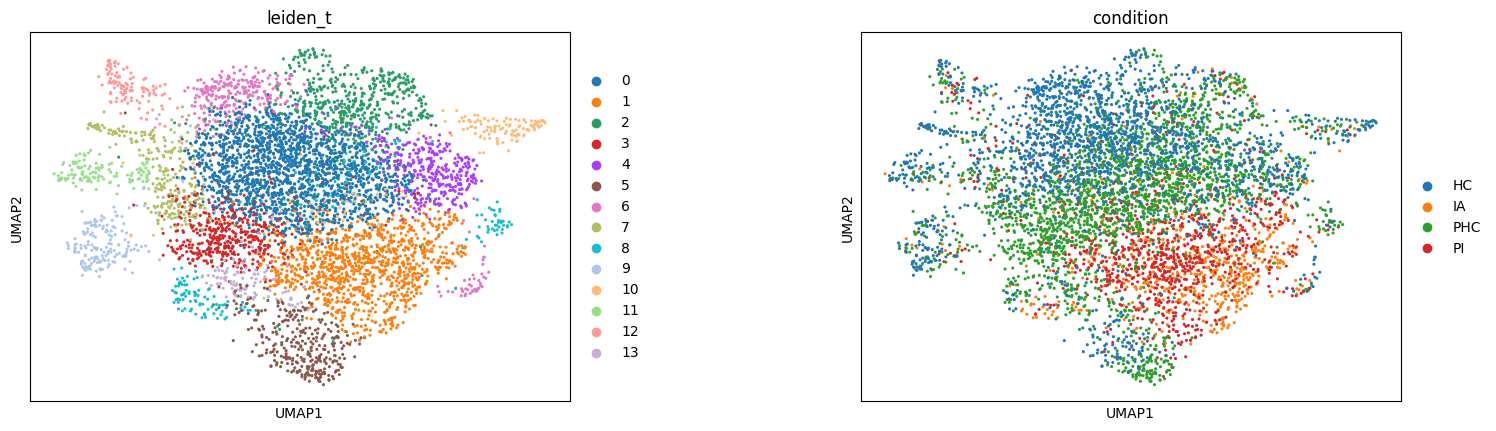

In [10]:
#Show UMAP
import matplotlib.pyplot as plt
import scanpy as sc

# Check that UMAP coordinates exist
print("Has X_umap:", "X_umap" in adata_t_an.obsm)

# Force UMAP plot rendering
sc.pl.umap(adata_t_an, color=["leiden_t", "condition"], wspace=0.4, show=True)
plt.show()

In [13]:
# Check which marker genes are present 
# Check which marker genes are actually present in the dataset
present = []
missing = []

for group, genes in tcell_markers.items():
    for g in genes:
        if g in adata_t_an.var_names:
            present.append(g)
        else:
            missing.append(g)

print("Present marker genes:")
print(sorted(set(present)))

print("\nMissing marker genes:")
print(sorted(set(missing)))

Present marker genes:
['CD3D', 'GNLY', 'GZMB', 'IL7R', 'LAG3', 'MKI67', 'NKG7', 'PRF1', 'TRAC']

Missing marker genes:
['CCR7', 'CD3E', 'CTLA4', 'FOXP3', 'IL2RA', 'LTB', 'PDCD1', 'TIGIT', 'TOP2A']


categories: 0, 1, 2, etc.
var_group_labels: T_cell_core, CD4_naive_memory, CD8_cytotoxic, etc.


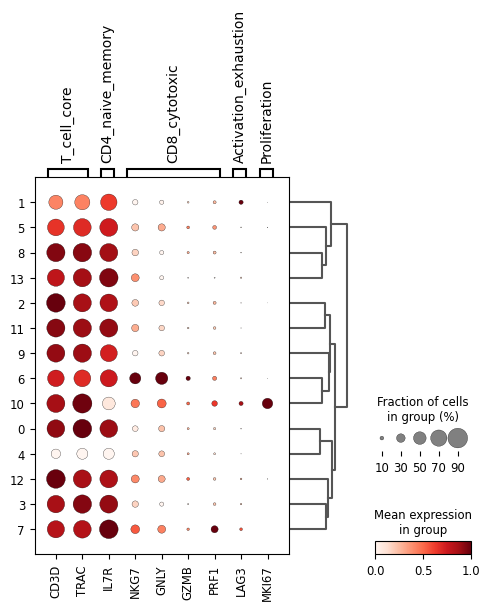

In [14]:
#Marker genes for T-cell subtype annotation: Identify DC4/CD8/cytotoxic/naive/proliferating T cells from Leiden clusters.
import scanpy as sc

# Canonical T-cell markers for subtype identification
tcell_markers = {
    "T_cell_core": ["CD3D", "TRAC"],
    "CD4_naive_memory": ["IL7R"],
    "CD8_cytotoxic": ["NKG7", "GNLY", "GZMB", "PRF1"],
    "Activation_exhaustion": ["LAG3"],
    "Proliferation": ["MKI67"]
}

# Dotplot to visualize marker expression across Leiden clusters
sc.pl.dotplot(
    adata_t_an,
    tcell_markers,
    groupby="leiden_t",
    standard_scale="var",
    dendrogram=True
)

In [15]:
# Figure saving setup
import os
import scanpy as sc

# Define output directory for NB07 figures
fig_dir = "../results/figures/NB07_Tcells"
os.makedirs(fig_dir, exist_ok=True)

# Tell scanpy to save figures there by default
sc.settings.figdir = fig_dir

print("Figures will be saved to:", sc.settings.figdir)

Figures will be saved to: ../results/figures/NB07_Tcells


In [25]:
# Assign T-cell bustypes + proportions by condition)
# Assign T-cell subtypes (conservative, based on marker dotplot)
tcell_cluster_map = {
    "4":  "CD4_naive_memory_like",
    "6":  "Cytotoxic_T",
    "10": "Cycling_T",
    "1":  "Activated_like_T"
    # others stay Mixed_or_unassigned
}

adata_t_an.obs["tcell_subtype"] = "Mixed_or_unassigned"
for clust, subtype in tcell_cluster_map.items():
    adata_t_an.obs.loc[adata_t_an.obs["leiden_t"] == clust, "tcell_subtype"] = subtype

print("T-cell subtypes (counts):")
print(adata_t_an.obs["tcell_subtype"].value_counts())


T-cell subtypes (counts):
tcell_subtype
Mixed_or_unassigned      4176
Activated_like_T         1033
CD4_naive_memory_like     374
Cytotoxic_T               302
Cycling_T                 159
Name: count, dtype: int64


In [17]:
# Proportions by condition - fixed
import pandas as pd

# Compute subtype proportions within each condition (robust pandas approach)
props = (
    adata_t_an.obs[["condition", "tcell_subtype"]]
    .value_counts(normalize=True)                # proportions over ALL rows
    .rename("proportion")
    .reset_index()
)

# IMPORTANT: normalize=True above gives proportions over the full table,
# so we re-normalize within each condition:
props["proportion"] = props.groupby("condition")["proportion"].transform(lambda x: x / x.sum())

print("Proportions by condition:")
print(props.sort_values(["condition", "proportion"], ascending=[True, False]))

# Save
out_path = "../results/tcells_tcell_subtype_proportions.tsv"
props.to_csv(out_path, sep="\t", index=False)
print(f"\nSaved to: {out_path}")

Proportions by condition:
   condition          tcell_subtype  proportion
1         HC    Mixed_or_unassigned    0.740000
5         HC            Cytotoxic_T    0.126842
7         HC  CD4_naive_memory_like    0.083158
9         HC              Cycling_T    0.037368
14        HC       Activated_like_T    0.012632
3         IA       Activated_like_T    0.620499
6         IA    Mixed_or_unassigned    0.322715
16        IA  CD4_naive_memory_like    0.022161
17        IA              Cycling_T    0.019391
18        IA            Cytotoxic_T    0.015235
0        PHC    Mixed_or_unassigned    0.877237
8        PHC  CD4_naive_memory_like    0.065751
10       PHC              Cycling_T    0.026633
12       PHC       Activated_like_T    0.017478
13       PHC            Cytotoxic_T    0.012901
2         PI       Activated_like_T    0.509323
4         PI    Mixed_or_unassigned    0.421001
11        PI  CD4_naive_memory_like    0.041217
15        PI            Cytotoxic_T    0.018646
19        PI  

/tmp/ipykernel_47756/2845045181.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  props["proportion"] = props.groupby("condition")["proportion"].transform(lambda x: x / x.sum())


In [21]:
#Create summary table for interpretation 
# Create a clean summary table (wide format) for interpretation
summary_table = (
    props
    .pivot(index="condition", columns="tcell_subtype", values="proportion")
    .fillna(0)
    .round(3)
)

print("Summary table: T-cell subtype proportions by condition")
summary_table

# Save the summary table (wide format) for reporting and README
summary_out = "../results/tcells_tcell_subtype_proportions_summary.tsv"
summary_table.to_csv(summary_out, sep="\t")

print(f"Summary table saved to: {summary_out}")

Summary table: T-cell subtype proportions by condition
Summary table saved to: ../results/tcells_tcell_subtype_proportions_summary.tsv


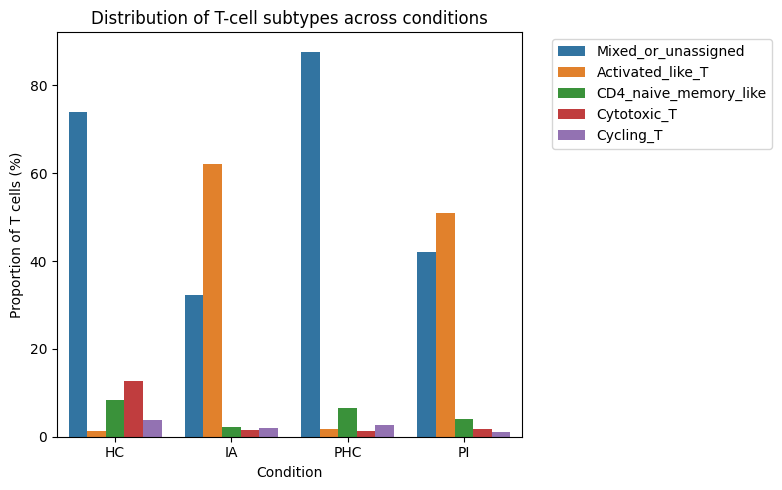

Figure saved to: ../results/figures/NB07_Tcells/tcell_subtype_proportions_barplot.png


In [24]:
# Proportions' barplot of all conditions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Explicit ordering ---
condition_order = ["HC", "IA", "PHC", "PI"]
subtype_order = [
    "Mixed_or_unassigned",
    "Activated_like_T",
    "CD4_naive_memory_like",
    "Cytotoxic_T",
    "Cycling_T"
]

# Prepare data
plot_df = props.copy()
plot_df["condition"] = pd.Categorical(
    plot_df["condition"], categories=condition_order, ordered=True
)
plot_df["tcell_subtype"] = pd.Categorical(
    plot_df["tcell_subtype"], categories=subtype_order, ordered=True
)
plot_df["proportion"] = plot_df["proportion"] * 100  # %

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_df,
    x="condition",
    y="proportion",
    hue="tcell_subtype",
    order=condition_order,
    hue_order=subtype_order
)

plt.ylabel("Proportion of T cells (%)")
plt.xlabel("Condition")
plt.title("Distribution of T-cell subtypes across conditions")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save
fig_out = "../results/figures/NB07_Tcells/tcell_subtype_proportions_barplot.png"
plt.savefig(fig_out, dpi=300)
plt.show()

print(f"Figure saved to: {fig_out}")


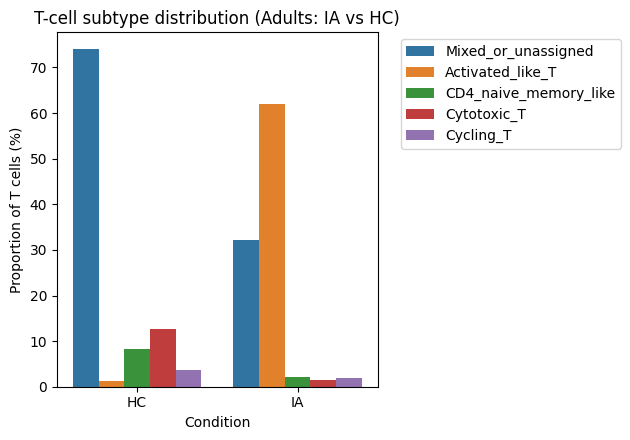

Saved: ../results/figures/NB07_Tcells/A1_adults_IA_vs_HC_tcell_subtypes.png


In [26]:
# IA vs HC (adults) barplots + save
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Subset to adult comparison only
adult_df = props[props["condition"].isin(["HC", "IA"])].copy()
adult_df["proportion"] = adult_df["proportion"] * 100  # %

# Explicit ordering
condition_order = ["HC", "IA"]
subtype_order = [
    "Mixed_or_unassigned",
    "Activated_like_T",
    "CD4_naive_memory_like",
    "Cytotoxic_T",
    "Cycling_T"
]

adult_df["condition"] = pd.Categorical(adult_df["condition"], categories=condition_order, ordered=True)
adult_df["tcell_subtype"] = pd.Categorical(adult_df["tcell_subtype"], categories=subtype_order, ordered=True)

# Plot
plt.figure(figsize=(6.5, 4.5))
sns.barplot(
    data=adult_df,
    x="condition",
    y="proportion",
    hue="tcell_subtype",
    order=condition_order,
    hue_order=subtype_order
)

plt.ylabel("Proportion of T cells (%)")
plt.xlabel("Condition")
plt.title("T-cell subtype distribution (Adults: IA vs HC)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save
fig_out = "../results/figures/NB07_Tcells/A1_adults_IA_vs_HC_tcell_subtypes.png"
plt.savefig(fig_out, dpi=300)
plt.show()

print(f"Saved: {fig_out}")


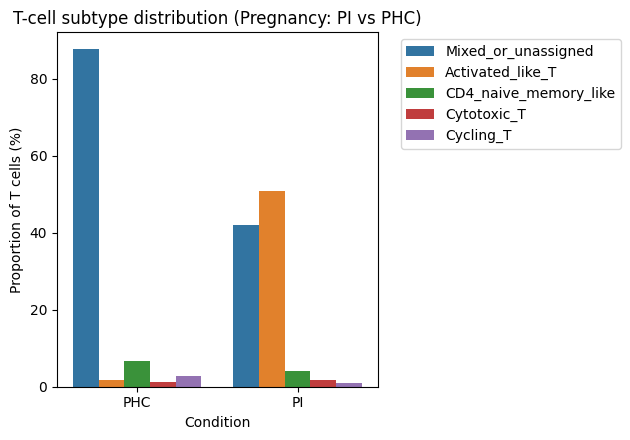

Saved: ../results/figures/NB07_Tcells/A2_pregnancy_PI_vs_PHC_tcell_subtypes.png


In [27]:
# PI vs HPC baroplot + save 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Subset to pregnancy comparison only
preg_df = props[props["condition"].isin(["PHC", "PI"])].copy()
preg_df["proportion"] = preg_df["proportion"] * 100  # %

# Explicit ordering
condition_order = ["PHC", "PI"]
subtype_order = [
    "Mixed_or_unassigned",
    "Activated_like_T",
    "CD4_naive_memory_like",
    "Cytotoxic_T",
    "Cycling_T"
]

preg_df["condition"] = pd.Categorical(preg_df["condition"], categories=condition_order, ordered=True)
preg_df["tcell_subtype"] = pd.Categorical(preg_df["tcell_subtype"], categories=subtype_order, ordered=True)

# Plot
plt.figure(figsize=(6.5, 4.5))
sns.barplot(
    data=preg_df,
    x="condition",
    y="proportion",
    hue="tcell_subtype",
    order=condition_order,
    hue_order=subtype_order
)

plt.ylabel("Proportion of T cells (%)")
plt.xlabel("Condition")
plt.title("T-cell subtype distribution (Pregnancy: PI vs PHC)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save
fig_out = "../results/figures/NB07_Tcells/A2_pregnancy_PI_vs_PHC_tcell_subtypes.png"
plt.savefig(fig_out, dpi=300)
plt.show()

print(f"Saved: {fig_out}")

In [28]:
# Save T-cell annotated object for Notebook 08
adata_t_an.write_h5ad("../results/adata_tcells_annotated.h5ad")

print("Saved: ../results/adata_tcells_annotated.h5ad")

Saved: ../results/adata_tcells_annotated.h5ad
